In [46]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [47]:
df_activity = pd.read_csv("dailyActivity_merged1.csv")
df_sleep = pd.read_csv("sleepDay_merged.csv")
df_body_metrics = pd.read_csv("weightLogInfo_merged.csv")
# print(df_activity[:1])
# print(df_sleep[:1])
# print(df_body_metrics[:1])

# First, standardize the date format in all dataframes
df_activity['ActivityDate'] = pd.to_datetime(df_activity['ActivityDate'])
df_sleep['SleepDay'] = pd.to_datetime(df_sleep['SleepDay'])
df_body_metrics['Date'] = pd.to_datetime(df_body_metrics['Date'])

merged_df = pd.merge(df_activity, df_sleep, 
                            left_on=['Id', 'ActivityDate'], 
                            right_on=['Id', 'SleepDay'], 
                            how='outer')
final_df = pd.merge(merged_df, df_body_metrics, 
                           left_on=['Id', 'ActivityDate'], 
                           right_on=['Id', 'Date'], 
                           how='outer')

# Drop the extra date columns 'SleepDay' and 'Date'
final_df = final_df.drop(columns=['SleepDay', 'Date'])
print(final_df.head())
# print(final_merged_df[:1])

# Count total rows in the dataframe
# print(len(final_merged_df))

# Check for null values
# print(final_merged_df.isnull().sum())

# Drop rows with null values
# final_merged_df = final_merged_df.dropna()
# print(len(final_merged_df))
# looks like every row has at least 1 null, shoot

# Fill null values with the mean of the column
# final_df.fillna(final_df.mean(), inplace=True)

final_df['TotalSteps'].mean()
# 7652.188759278897

final_df = final_df.drop(columns=['Id', 'ActivityDate', 'TrackerDistance','SedentaryActiveDistance', 'LoggedActivitiesDistance', 
                                  'LoggedActivitiesDistance', 'WeightKg', 'WeightPounds', 'BMI', 'Fat', 'IsManualReport', 'LogId', 
                                  'TotalSleepRecords'])

final_df['SleepEfficiency'] = final_df['TotalMinutesAsleep'] / final_df['TotalTimeInBed'] * 100
final_df = final_df.dropna(subset=['SleepEfficiency'])
final_df = final_df.dropna(subset=['TotalMinutesAsleep'])


final_df.to_csv('final_dataset.csv', index=False)

           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366   2016-04-12     13162.0           8.50             8.50   
1  1503960366   2016-04-13     10735.0           6.97             6.97   
2  1503960366   2016-04-14     10460.0           6.74             6.74   
3  1503960366   2016-04-15      9762.0           6.28             6.28   
4  1503960366   2016-04-16     12669.0           8.16             8.16   

   LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0                       0.0                1.88                      0.55   
1                       0.0                1.57                      0.69   
2                       0.0                2.44                      0.40   
3                       0.0                2.14                      1.26   
4                       0.0                2.71                      0.41   

   LightActiveDistance  SedentaryActiveDistance  ...  Calories  \
0                 6.06    

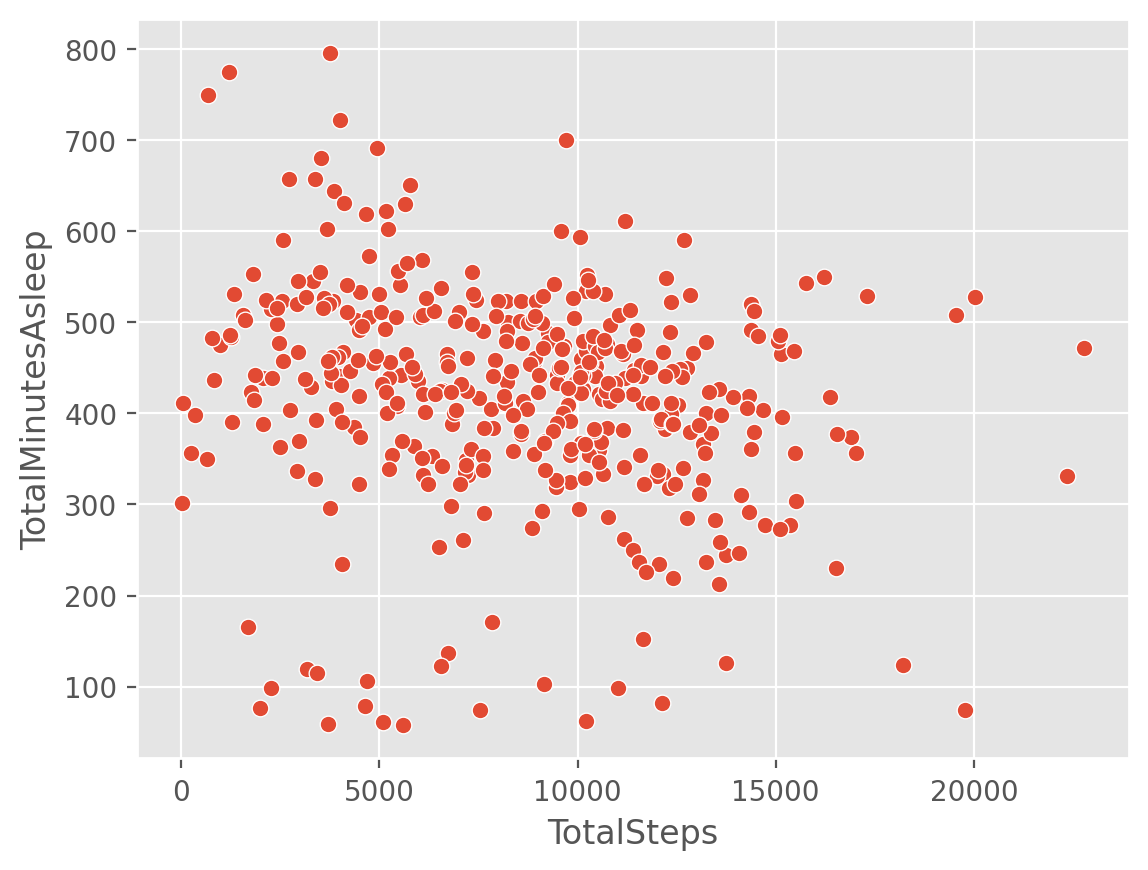

In [49]:
# initial data exploration
# plt.plot(final_df['TotalSteps'], final_df['TotalMinutesAsleep'], 'o', alpha=0.5)
# plt.xlabel('Total Steps')
# plt.ylabel('Total Minutes Asleep')
# plt.title('Total Steps vs Total Minutes Asleep')
# plt.show()

# only use rows with no null values for very active distance and total minutes asleep
# plot_df = final_df.dropna(subset=['VeryActiveDistance', 'TotalMinutesAsleep'])
# plt.plot(plot_df['VeryActiveDistance'], plot_df['TotalMinutesAsleep'], 'o', alpha=0.5)
# plt.xlabel('Very Active Distance')
# plt.ylabel('Total Minutes Asleep')
# plt.title('Very Active Distance vs Total Minutes Asleep')

# final_df.plot(x='ActivityDate', y='TotalSteps')

# Scatter plot of TotalSteps vs TotalMinutesAsleep
sns.scatterplot(data=final_df, x='TotalSteps', y='TotalMinutesAsleep')
plt.show()

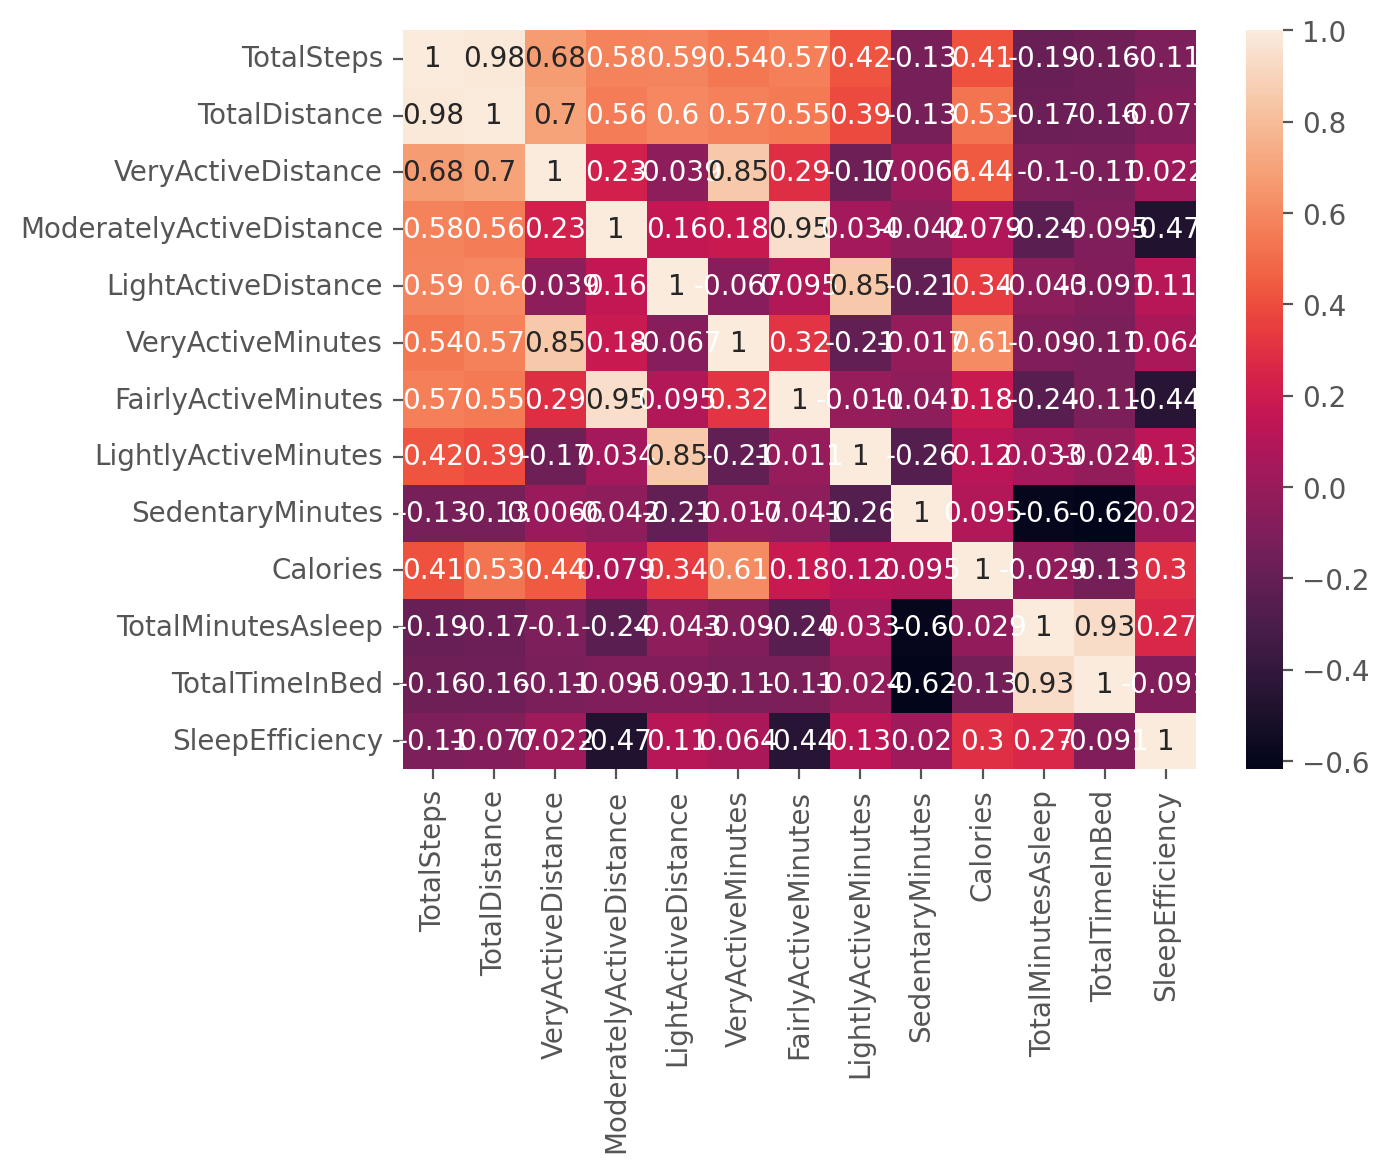

In [50]:
import pandas as pd
import seaborn as sns

correlation_matrix = final_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

C:\Users\boon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


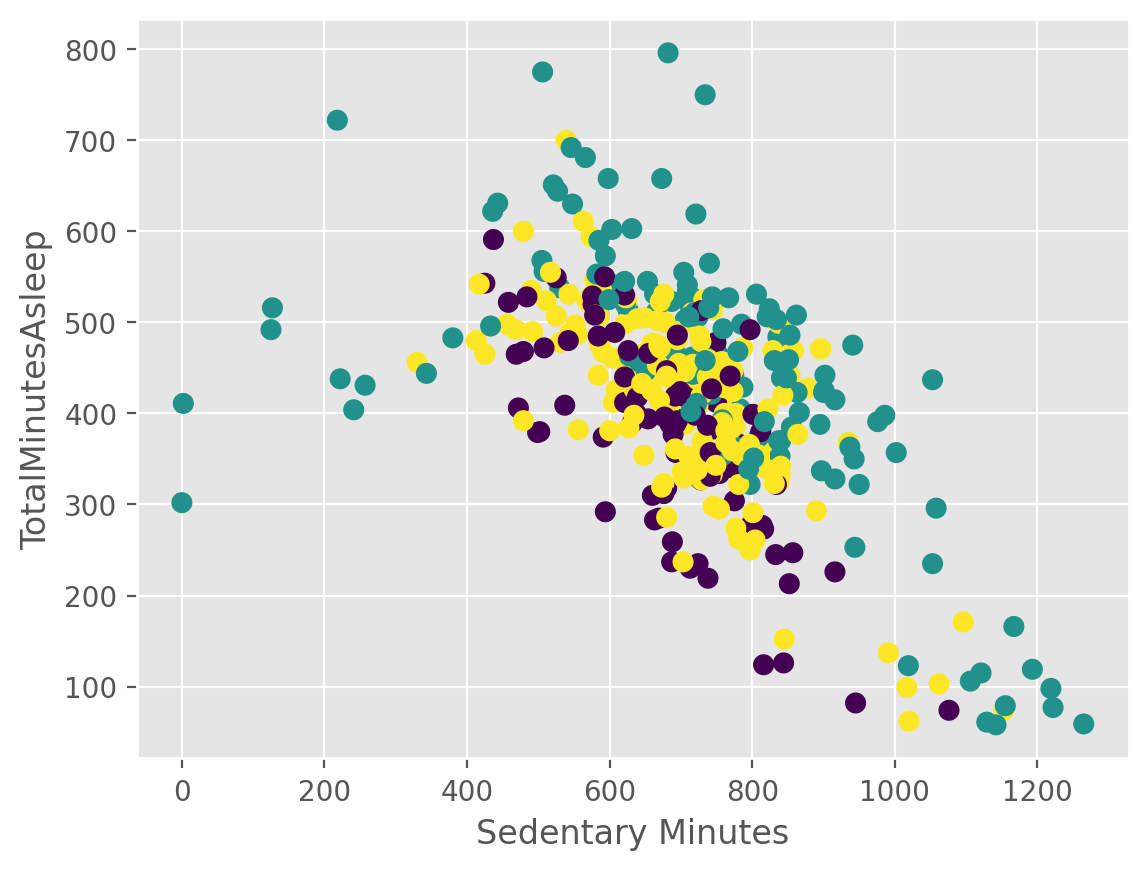

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(final_df)

y_kmeans = kmeans.predict(final_df)

plt.xlabel('Sedentary Minutes')
plt.ylabel('TotalMinutesAsleep')
plt.scatter(final_df['SedentaryMinutes'],
            final_df['TotalMinutesAsleep'],
            c=y_kmeans, s=50, cmap='viridis')


In [52]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(final_df, y_kmeans)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.4972036618331126


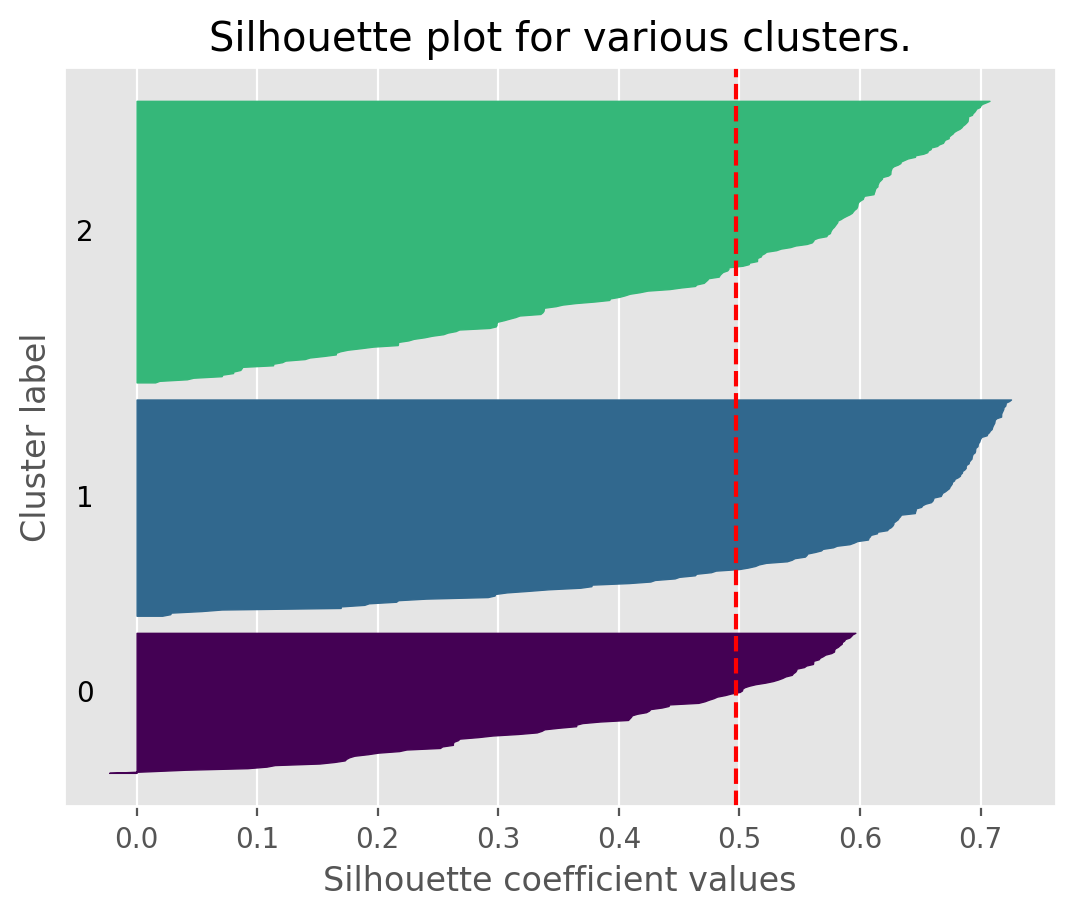

In [59]:
from sklearn.metrics import silhouette_samples

silhouette_values = silhouette_samples(final_df, y_kmeans)

fig, ax = plt.subplots(1, 1)
y_lower = 10
for i in range(3):  # Here 3 is the number of clusters
    ith_cluster_silhouette_values = silhouette_values[y_kmeans == i]                                                        # type: ignore
    ith_cluster_silhouette_values.sort()                                                                                    # type: ignore

    size_cluster_i = ith_cluster_silhouette_values.shape[0]                                                                 # type: ignore
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / 3)                                                                                    # type: ignore
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,                                         # type: ignore
                     facecolor=color, edgecolor=color)                                                                       # type: ignore

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax.set_title("Silhouette plot for various clusters.")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values  
ax.axvline(x=silhouette_avg, color="red", linestyle="--")                                                                   # type: ignore
ax.set_yticks([])  # Clear the yaxis labels / ticks
plt.show()

Original shape: (413, 13)
Reduced shape: (413, 2)


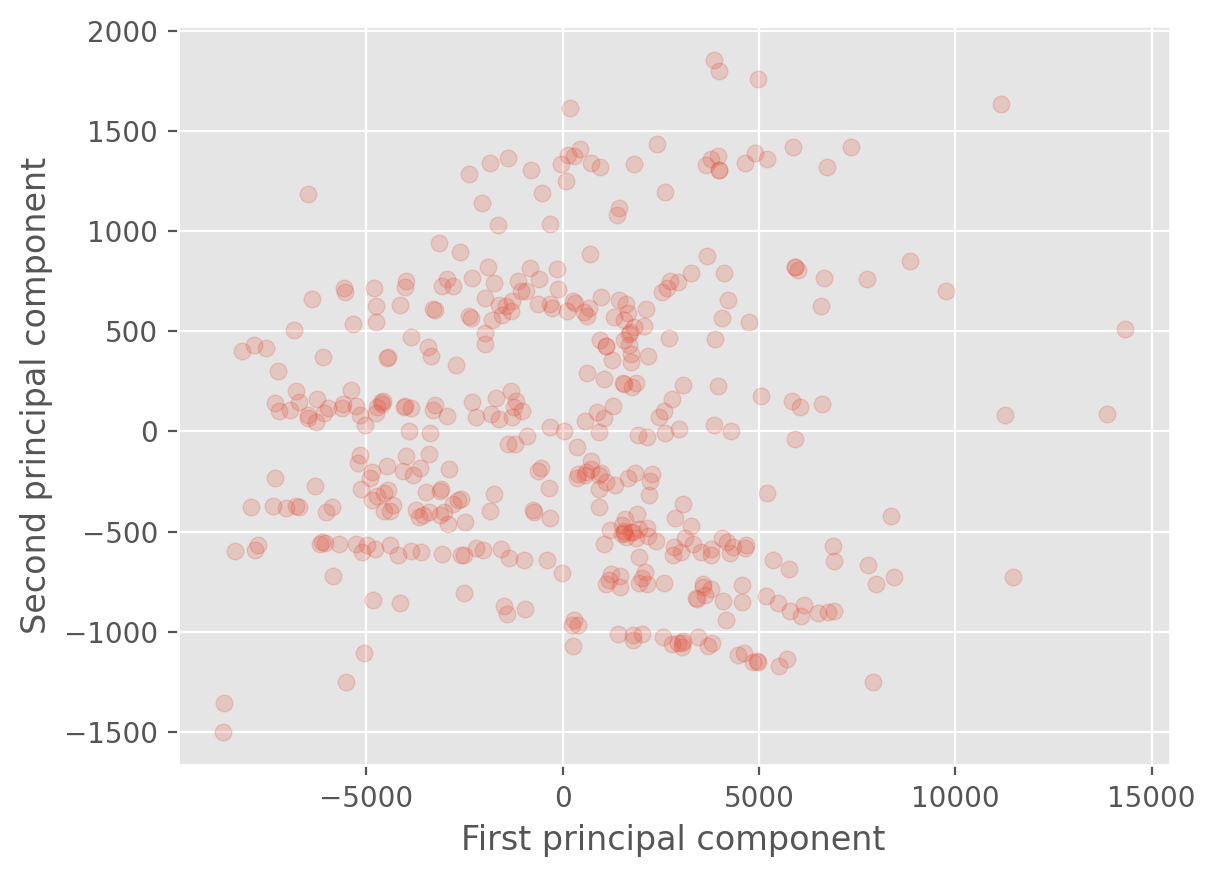

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(final_df)
X_pca = pca.transform(final_df)
print("Original shape: {}".format(str(final_df.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)

C:\Users\boon\AppData\Local\Temp\ipykernel_3600\3097704101.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(final_df['SedentaryMinutes'], final_df['TotalMinutesAsleep'], s=50, cmap='viridis')


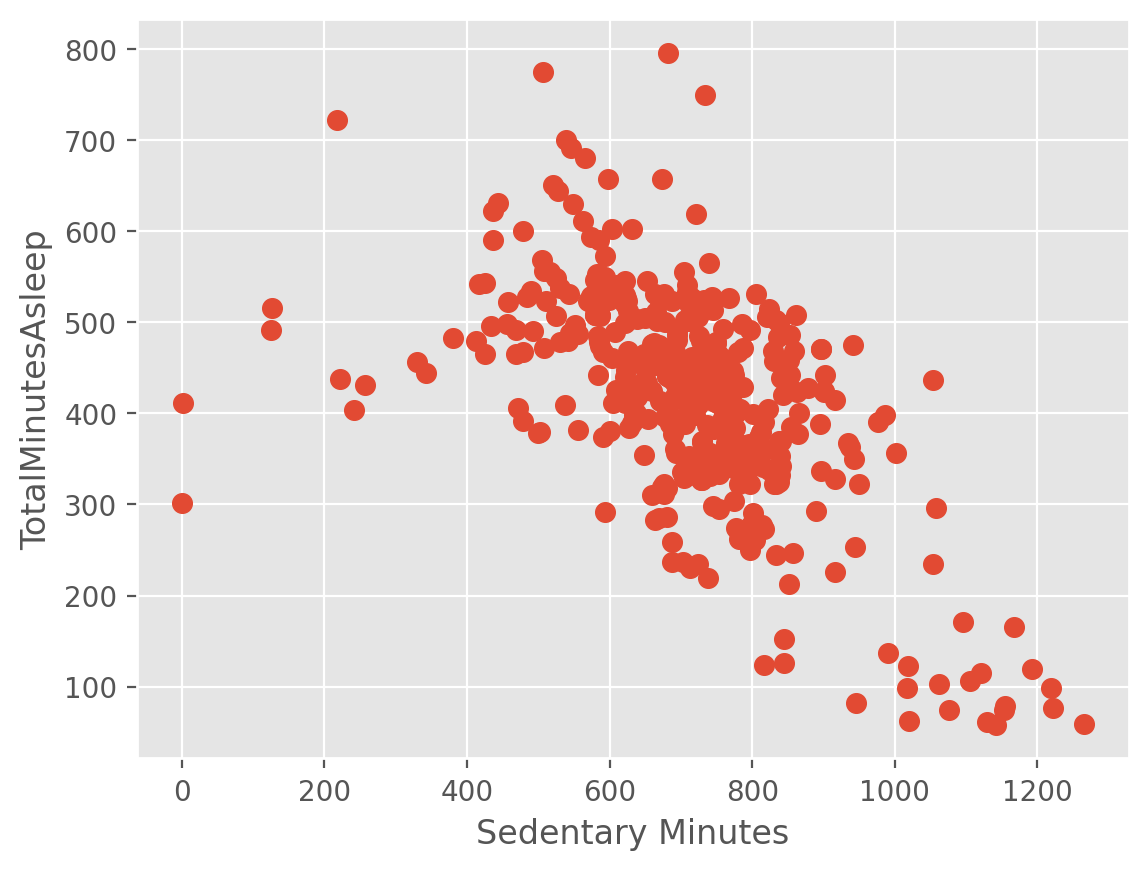

In [61]:

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

inputs = final_df[['TotalDistance', 'TotalSteps']]
target = final_df['TotalMinutesAsleep']

# inputs.shape
# target.shape

X_train, X_test, y_train, y_test = train_test_split(inputs, target, random_state=0)
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)
# print("Test set predictions: {}".format(model.predict(X_test)))
model.score(X_test, y_test)

plt.xlabel('Sedentary Minutes')
plt.ylabel('TotalMinutesAsleep')
plt.scatter(final_df['SedentaryMinutes'], final_df['TotalMinutesAsleep'], s=50, cmap='viridis')
